# 🧠 Custom Deep CNN for CIFAR-10 (PyTorch)

This notebook builds and trains a custom convolutional neural network with residual-style connections on the CIFAR-10 dataset. The network is constructed entirely from scratch using PyTorch and trained with modern techniques like batch normalization, dropout, and OneCycle learning rate scheduling.

**Highlights:**
- Residual-style skip connections using 1×1 convolutions
- Fully connected layer at the end
- Custom CNN (not ResNet or pretrained)
- Data augmentation + normalization
- Achieves **91.81% test accuracy**


In [1]:
# Import libraries for training the CNN

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


In [2]:
# Define train/test dataloaders with transforms (augmentation + normalization)

def get_dataloaders(train_size=45000, test_size=5000, batch_size=400):
    normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std =[0.2470, 0.2435, 0.2616]
    )

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])

    full_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    full_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    # Optional, to decide if to use a subset for training and testing
    train_subset = torch.utils.data.Subset(full_train, range(train_size))
    test_subset = torch.utils.data.Subset(full_test, range(test_size))

    # Took the full size sets
    trainloader = DataLoader(full_train, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(full_test, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, testloader

In [3]:
# Define a custom deep CNN with skip connections between blocks

class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3,16, 3, 1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 1, padding=1 ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )

        self.pool1 = nn.MaxPool2d(2) # 32 -> 16

        self.b1_to_b2 = nn.Sequential(
            nn.Conv2d(3, 32, 1, 2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )


        self.pool2 = nn.MaxPool2d(2) # 16 -> 8

        self.b2_to_b3 = nn.Sequential(
            nn.Conv2d(32, 128, 1, 2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, 1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.pool3 = nn.MaxPool2d(2) # 8 -> 4

        self.b3_to_b4 = nn.Sequential(
            nn.Conv2d(128, 256, 1, 2)
        )


        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
        )

        self.output = nn.Sequential(
            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        skip = self.b1_to_b2(x)
        x = self.pool1(self.block1(x)) + skip

        skip = self.b2_to_b3(x)
        x = self.pool2(self.block2(x)) + skip

        skip = self.b3_to_b4(x)
        x = self.pool3(self.block3(x)) + skip

        x = self.block4(x)
        return self.output(x)

In [4]:
trainloader, testloader = get_dataloaders()


100%|██████████| 170M/170M [00:03<00:00, 43.7MB/s]


# Define loss function, optimizer, and OneCycleLR scheduler
# OneCycleLR helps with faster convergence and better generalization



In [7]:
import torch.optim as optim

# Model
model = MyCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,max_lr=1e-2, epochs=40, steps_per_epoch=len(trainloader))



In [8]:
# Training and evaluation loop for 40 epochs
# Tracks: training loss, training accuracy, test loss, test accuracy

%%time
train_losses, test_losses, train_accs, test_accs = [], [], [], []

for epoch in range(40):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # # Backward and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            scheduler.step()



            # Track training loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()




        train_loss = running_loss / total
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Evaluation
        model.eval()
        test_loss, correct_test, total_test = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total_test += labels.size(0)
                correct_test += predicted.eq(labels).sum().item()

        test_loss /= total_test
        test_acc = 100. * correct_test / total_test
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f"Epoch [{epoch+1}/{40}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch [1/40] Train Loss: 1.4491, Train Acc: 47.39% | Test Loss: 1.2084, Test Acc: 56.51%
Epoch [2/40] Train Loss: 1.0185, Train Acc: 63.52% | Test Loss: 1.0194, Test Acc: 63.79%
Epoch [3/40] Train Loss: 0.8323, Train Acc: 70.75% | Test Loss: 1.0254, Test Acc: 65.84%
Epoch [4/40] Train Loss: 0.7350, Train Acc: 74.36% | Test Loss: 0.7643, Test Acc: 73.98%
Epoch [5/40] Train Loss: 0.6662, Train Acc: 76.70% | Test Loss: 0.7282, Test Acc: 75.59%
Epoch [6/40] Train Loss: 0.6238, Train Acc: 78.43% | Test Loss: 0.7486, Test Acc: 74.30%
Epoch [7/40] Train Loss: 0.6114, Train Acc: 79.09% | Test Loss: 0.7085, Test Acc: 76.48%
Epoch [8/40] Train Loss: 0.5575, Train Acc: 81.01% | Test Loss: 0.7132, Test Acc: 75.62%
Epoch [9/40] Train Loss: 0.5366, Train Acc: 81.48% | Test Loss: 0.7759, Test Acc: 75.54%
Epoch [10/40] Train Loss: 0.5072, Train Acc: 82.50% | Test Loss: 0.7001, Test Acc: 76.74%
Epoch [11/40] Train Loss: 0.4937, Train Acc: 83.07% | Test Loss: 0.6825, Test Acc: 77.47%
Epoch [12/40] Train

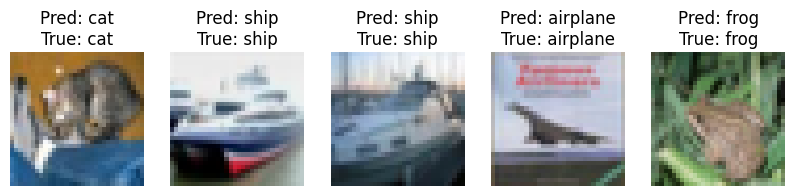

In [16]:
# 🔍 Run inference on a few test images to visualize predictions
import matplotlib.pyplot as plt

classes = trainloader.dataset.classes
dataiter = iter(testloader)
images, labels = next(dataiter)

# Move model to eval mode
model.eval()
images = images.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Show predictions
fig = plt.figure(figsize=(10,4))
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)
    img = images[i].cpu().permute(1, 2, 0)
    img = img * torch.tensor([0.2470, 0.2435, 0.2616]) + torch.tensor([0.4914, 0.4822, 0.4465])  # unnormalize
    ax.imshow(img.clip(0,1))
    ax.set_title(f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}")
    ax.axis('off')


In [18]:
# Calculate Model Parameters

model = MyCNN()
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"~{total_params / 1e6:.2f} million parameters")


Total parameters: 4,125,962
~4.13 million parameters


# 📈 Plot: Test Accuracy vs Epochs


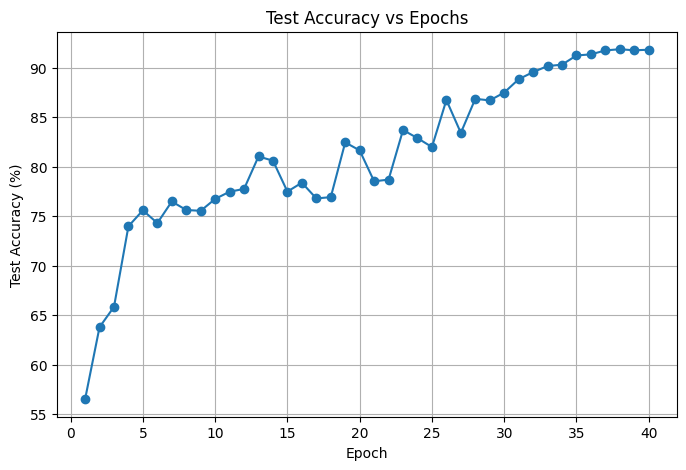

In [15]:
import matplotlib.pyplot as plt
def plot_test_acc():
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 41), test_accs, marker='o')
    plt.title("Test Accuracy vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Test Accuracy (%)")
    plt.grid(True)
    plt.show()
plot_test_acc()

# 📉 Plot: Training and Test Loss vs Epochs


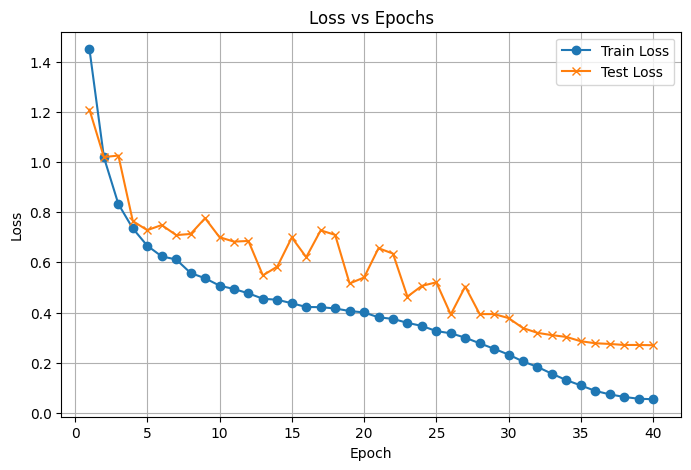

In [14]:
# Plot Train and Test Loss
def plot_train_test_loss():
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 41), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, 41), test_losses, label='Test Loss', marker='x')
    plt.title("Loss vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_train_test_loss()

## ✅ Summary & Takeaways

This project demonstrates how to design and train a deep convolutional neural network from scratch for image classification. Despite not using any pretrained models, the custom architecture reaches over **91% accuracy** on the CIFAR-10 dataset.

**Techniques used:**
- Deep custom CNN with skip connections
- Data augmentation & normalization
- Batch normalization and dropout
- OneCycleLR scheduler

The model generalizes well, remains efficient, and can be further improved via advanced regularization or ensemble methods.
